In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]
TARGETID = d['TARGETID'][SEL][~indice]
d = Planck18.distmod(z).value

In [4]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
apr_mag_g = apr_mag_g[indices]
apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d = d[indices]
z = z[indices]
k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [5]:
abs_mag_g = apr_mag_g - d - k_gg
abs_mag_r = apr_mag_r - d - k_rr

In [6]:
mag_g_bins = np.linspace(np.min(abs_mag_g), np.max(abs_mag_g), 10)

z_bins = np.linspace(np.min(z), np.max(z), 10)
counts_g,z_edges,mag_g_edges= np.histogram2d(z, abs_mag_g, bins=[z_bins, mag_g_bins])

In [7]:
mag_g_bin_widths = np.diff(mag_g_bins)[0]  # Differences between consecutive bin edges for magnitude
z_bin_widths = np.diff(z_bins)[0]          # Differences between consecutive bin edges for redshift

In [8]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    d1 = cosmo.comoving_distance(z1).value# Mpc
    d2 = cosmo.comoving_distance(z2).value# Mpc
    return 4/3 * np.pi * (d2**3 - d1**3)  # Mpc^3

In [9]:
L_g_edges = abs_mag_to_L(mag_g_edges)  # Luminosities for each magnitude bin
volumes = np.array([comoving_volume(z_edges[i], z_edges[i+1]) for i in range(len(z_edges)-1)])  # Total comoving volume

In [10]:
delta_log_L_g = -np.diff(np.log10(L_g_edges))

In [11]:
print(delta_log_L_g)

[0.36585795 0.36585795 0.36585795 0.36585795 0.36585795 0.36585795
 0.36585795 0.36585795 0.36585795]


In [12]:
phi_g = np.zeros_like(counts_g)
for i in range(len(z_bins)-1):
    for j in range(len(mag_g_bins)-1):
        phi_g[i, j] = counts_g[i, j] / (volumes[i] * delta_log_L_g[j])/0.16

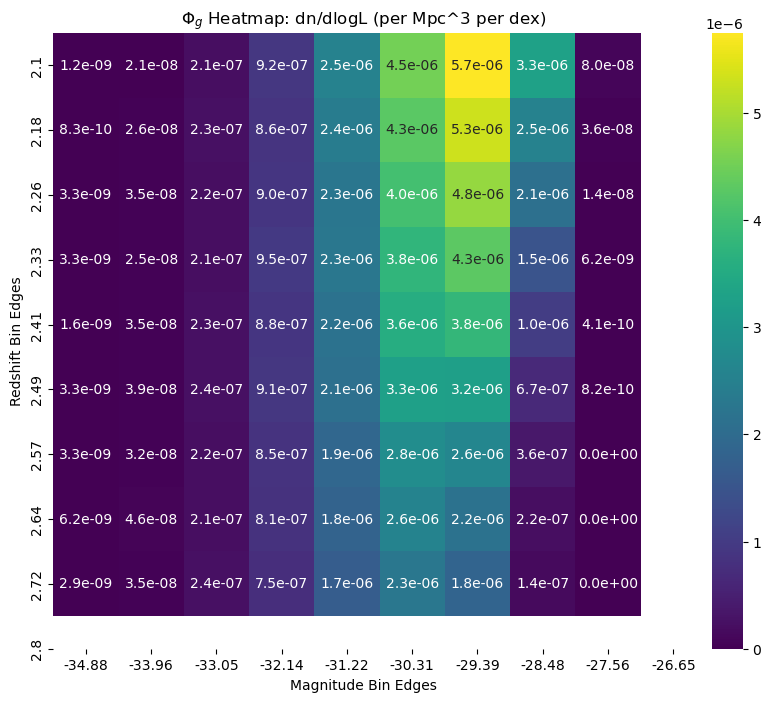

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(phi_g, xticklabels=np.round(mag_g_edges, 2), yticklabels=np.round(z_edges, 2), annot=True, fmt=".1e", cmap='viridis')
plt.title('$\Phi_g$ Heatmap: dn/dlogL (per Mpc^3 per dex)')
plt.xlabel('Magnitude Bin Edges')
plt.ylabel('Redshift Bin Edges')
plt.show()

/tmp/ipykernel_939681/3851370523.py:9: RuntimeWarning: divide by zero encountered in log
  surf = ax.plot_surface(Mag_g, Z, np.log(phi_g), cmap='viridis', edgecolor='none')
/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:124: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


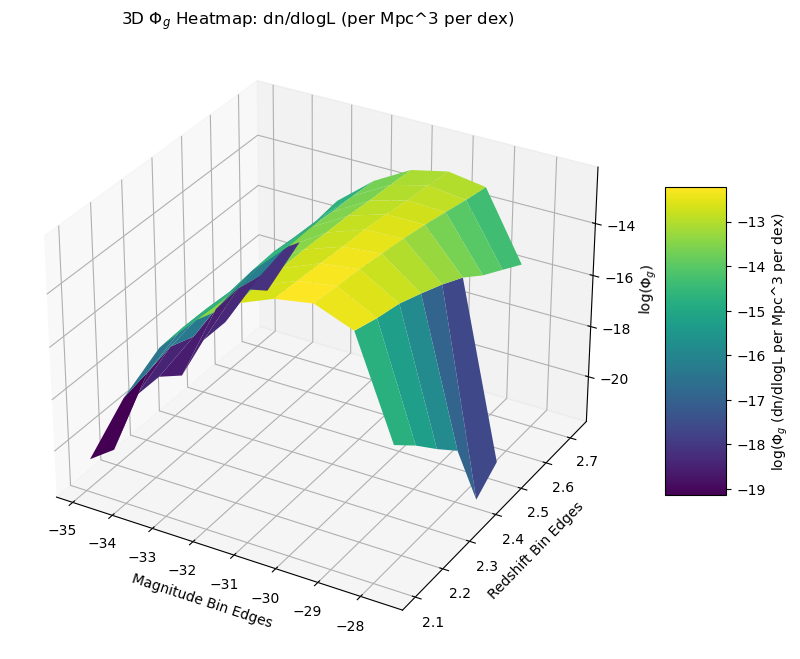

In [14]:
# Creating a meshgrid for the bin edges
Mag_g, Z = np.meshgrid(mag_g_edges[:-1], z_edges[:-1])

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surf = ax.plot_surface(Mag_g, Z, np.log(phi_g), cmap='viridis', edgecolor='none')

# Adding a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('log($\Phi_g$ (dn/dlogL per Mpc^3 per dex)')

# Labels and title
ax.set_xlabel('Magnitude Bin Edges')
ax.set_ylabel('Redshift Bin Edges')
ax.set_zlabel('log($\Phi_g$)')
ax.set_title('3D $\Phi_g$ Heatmap: dn/dlogL (per Mpc^3 per dex)')

# Show the plot
plt.show()

## Prediction by luminosity function

In [15]:
phi_g_prediction = np.zeros((len(z_bins)-1, len(mag_g_bins)-1))

for i in range(len(z_bins)-1):
    z_mid = 0.5 * (z_bins[i] + z_bins[i+1])
    
    for j in range(len(mag_g_bins)-1):
        M_mid = 0.5 * (mag_g_bins[j] + mag_g_bins[j+1])
        L_mid = abs_mag_to_L(M_mid)
        phi_g_prediction[i,j] = get_phis(L_mid, z_mid,"shen20" )

print(phi_g_prediction)

[[3.83131980e-12 3.22826939e-11 2.71995535e-10 2.29075575e-09
  1.92466168e-08 1.59438183e-07 1.22065298e-06 6.65722416e-06
  1.80756066e-05]
 [4.03799168e-12 3.38367983e-11 2.83518143e-10 2.37454929e-09
  1.98357794e-08 1.63186519e-07 1.23392322e-06 6.54699062e-06
  1.72725536e-05]
 [4.23509840e-12 3.52480172e-11 2.93339527e-10 2.44004926e-09
  2.02397149e-08 1.65160020e-07 1.23256932e-06 6.37592717e-06
  1.64275841e-05]
 [4.42060991e-12 3.65000872e-11 3.01347181e-10 2.48665527e-09
  2.04575526e-08 1.65403231e-07 1.21769484e-06 6.15537336e-06
  1.55602379e-05]
 [4.59274478e-12 3.75805584e-11 3.07476789e-10 2.51431449e-09
  2.04942003e-08 1.64016319e-07 1.19077092e-06 5.89617136e-06
  1.46859211e-05]
 [4.74999911e-12 3.84808880e-11 3.11710450e-10 2.52347283e-09
  2.03595327e-08 1.61143676e-07 1.15350450e-06 5.60828582e-06
  1.38166023e-05]
 [4.89116394e-12 3.91963759e-11 3.14073083e-10 2.51500774e-09
  2.00674175e-08 1.56961608e-07 1.10771790e-06 5.30059911e-06
  1.29614355e-05]
 [5.01

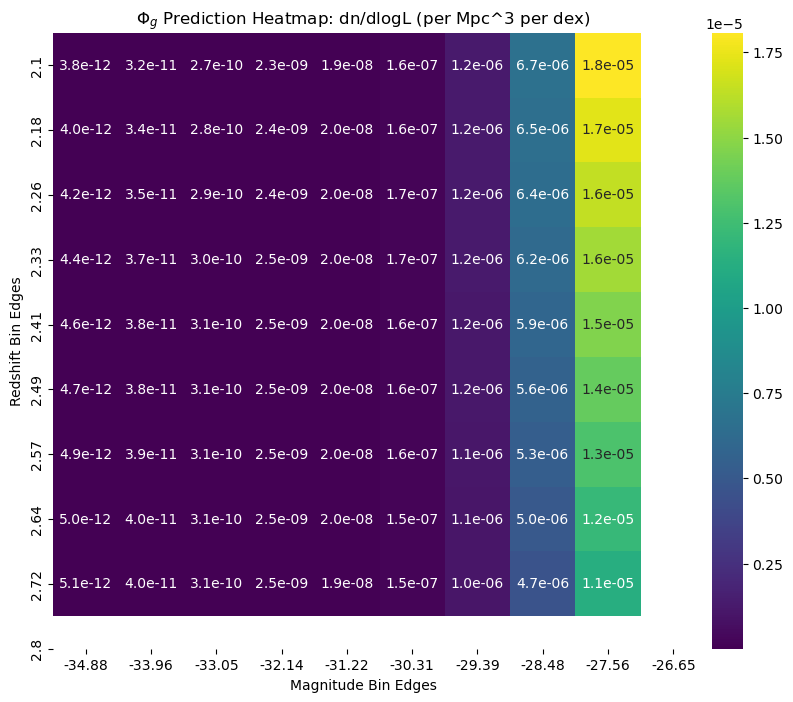

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(phi_g_prediction, xticklabels=np.round(mag_g_edges, 2), yticklabels=np.round(z_edges, 2), annot=True, fmt=".1e", cmap='viridis')
plt.title('$\Phi_g$ Prediction Heatmap: dn/dlogL (per Mpc^3 per dex)')
plt.xlabel('Magnitude Bin Edges')
plt.ylabel('Redshift Bin Edges')
plt.show()

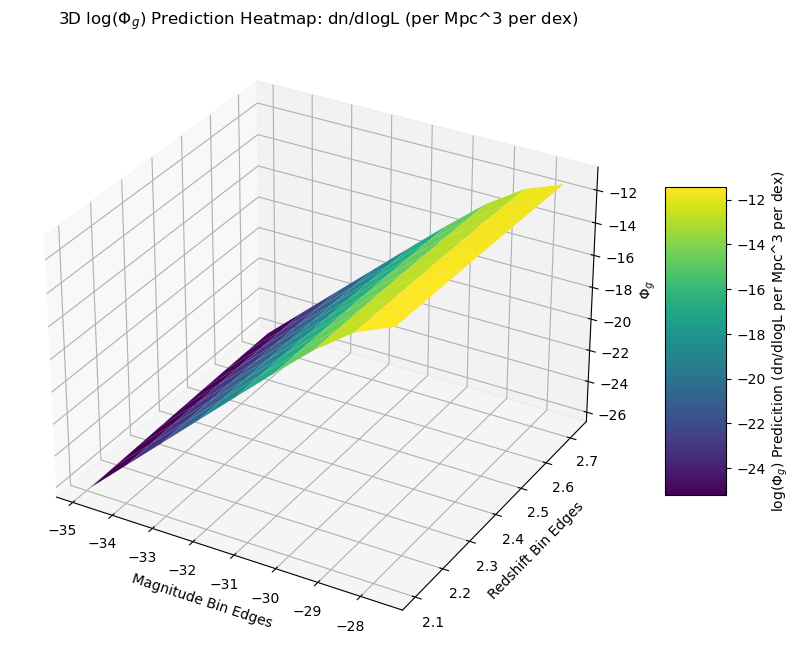

In [17]:
# Creating a meshgrid for the bin edges
Mag_g, Z = np.meshgrid(mag_g_edges[:-1], z_edges[:-1])

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surf = ax.plot_surface(Mag_g, Z, np.log(phi_g_prediction), cmap='viridis', edgecolor='none')

# Adding a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('log($\Phi_g$) Predicition (dn/dlogL per Mpc^3 per dex)')

# Labels and title
ax.set_xlabel('Magnitude Bin Edges')
ax.set_ylabel('Redshift Bin Edges')
ax.set_zlabel('$\Phi_g$')
ax.set_title('3D log($\Phi_g$) Prediction Heatmap: dn/dlogL (per Mpc^3 per dex)')

# Show the plot
plt.show()

## Compare

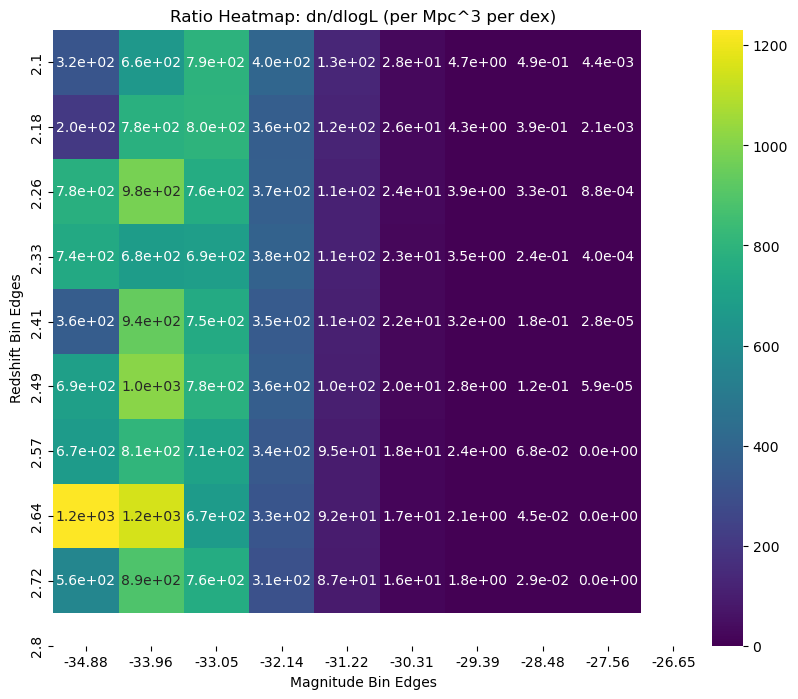

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(phi_g/phi_g_prediction, xticklabels=np.round(mag_g_edges, 2), yticklabels=np.round(z_edges, 2), annot=True, fmt=".1e", cmap='viridis')
plt.title('Ratio Heatmap: dn/dlogL (per Mpc^3 per dex)')
plt.xlabel('Magnitude Bin Edges')
plt.ylabel('Redshift Bin Edges')
plt.show()

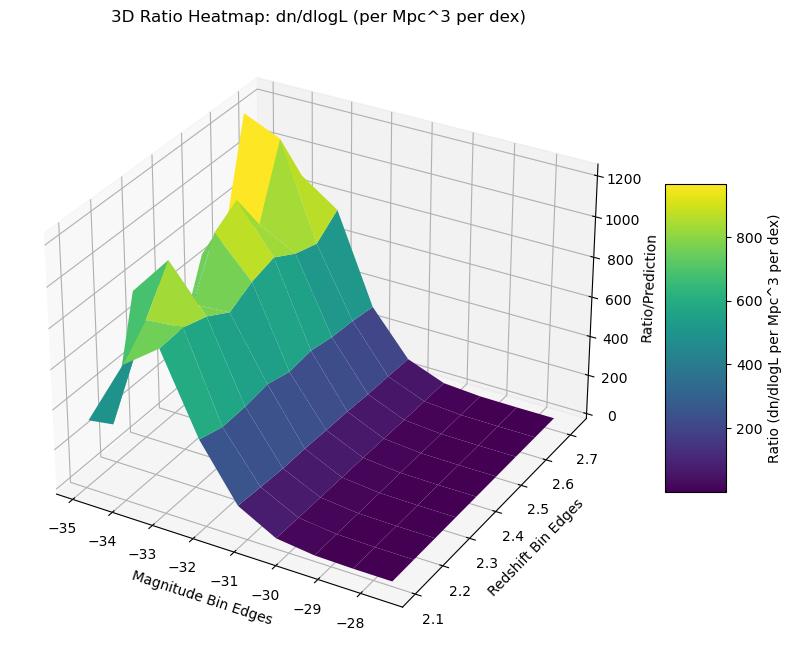

In [19]:
# Creating a meshgrid for the bin edges
Mag_g, Z = np.meshgrid(mag_g_edges[:-1], z_edges[:-1])

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surf = ax.plot_surface(Mag_g, Z, phi_g/phi_g_prediction, cmap='viridis', edgecolor='none')

# Adding a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Ratio (dn/dlogL per Mpc^3 per dex)')

# Labels and title
ax.set_xlabel('Magnitude Bin Edges')
ax.set_ylabel('Redshift Bin Edges')
ax.set_zlabel('Ratio/Prediction')
ax.set_title('3D Ratio Heatmap: dn/dlogL (per Mpc^3 per dex)')

# Show the plot
plt.show()

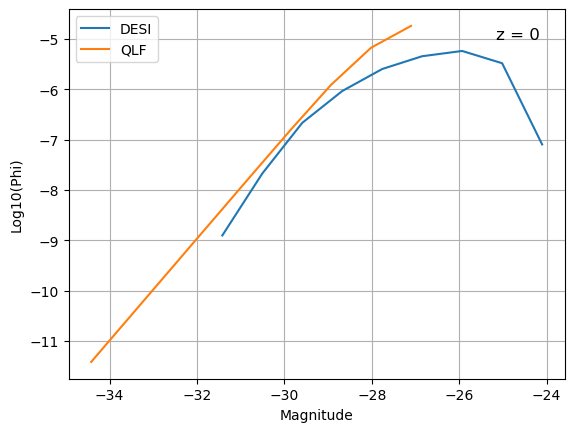

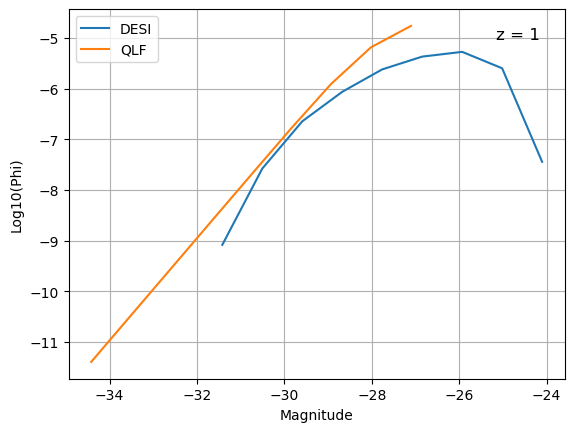

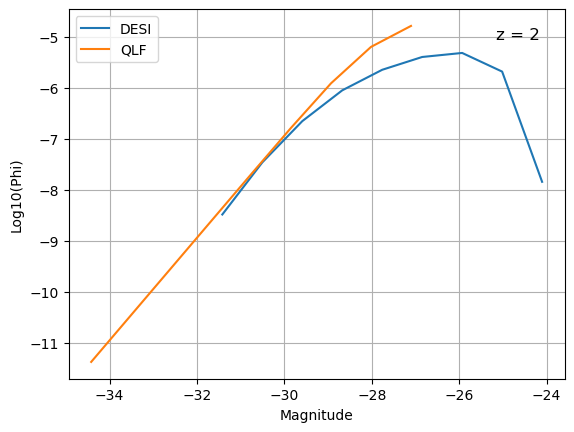

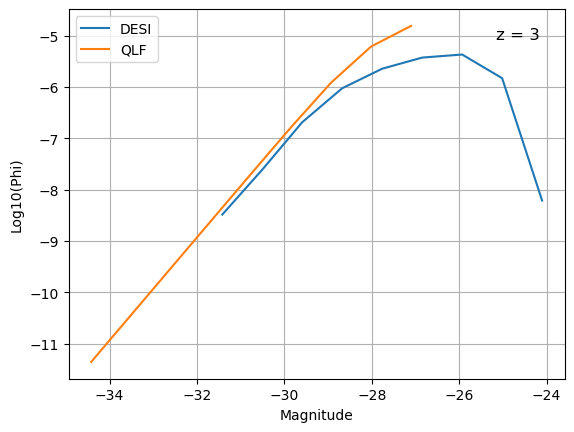

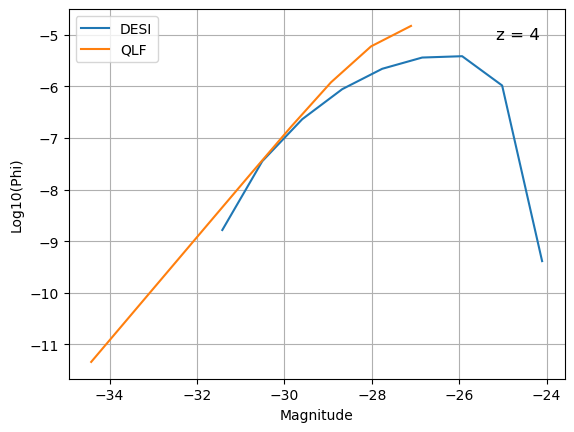

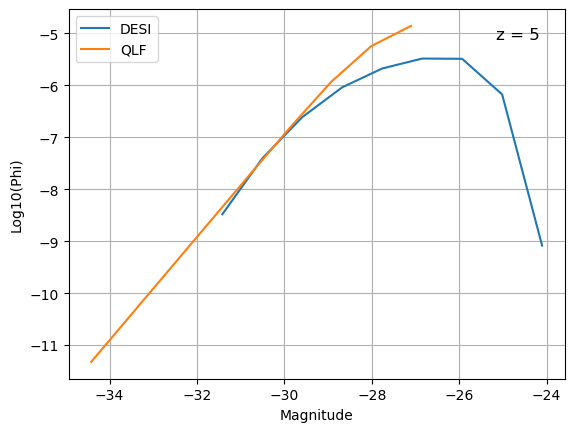

/tmp/ipykernel_939681/722148966.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(mag_g_cens+3, np.log10(phi_g[i,:]),label='DESI')


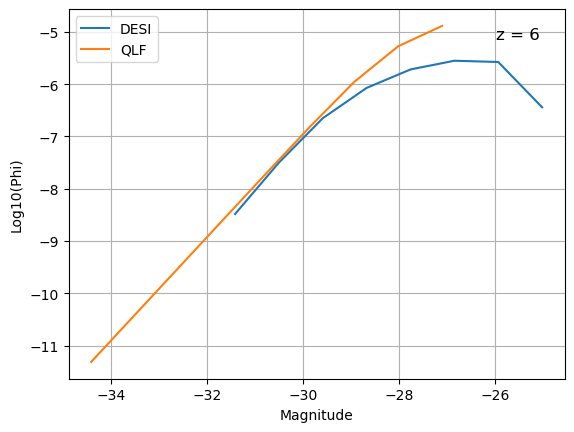

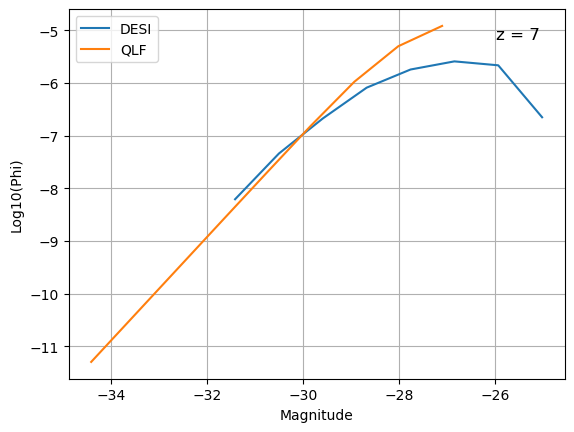

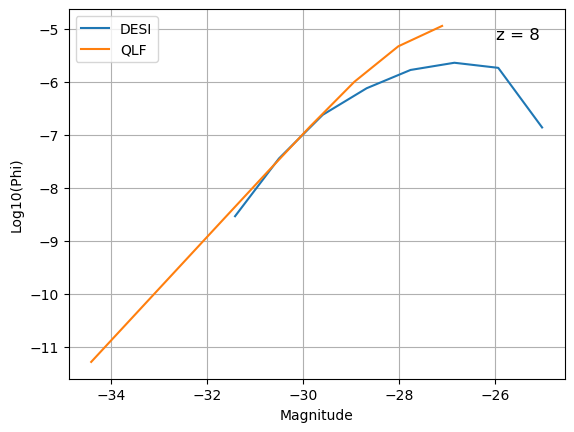

In [31]:
for i in range(0,9):
    mag_g_cens = 0.5*(mag_g_bins[1:]+mag_g_bins[:-1])
    plt.plot(mag_g_cens+3, np.log10(phi_g[i,:]),label='DESI')
    plt.plot(mag_g_cens,np.log10(phi_g_prediction[i,:]),label='QLF')
    plt.grid()
    plt.xlabel('Magnitude')  # Label for the x-axis
    plt.ylabel('Log10(Phi)')  # Label for the y-axis
    plt.legend(loc='upper left')
    plt.text(0.95, 0.95, f'z = {i}', fontsize=12, ha='right', va='top', transform=plt.gca().transAxes)
    plt.show()

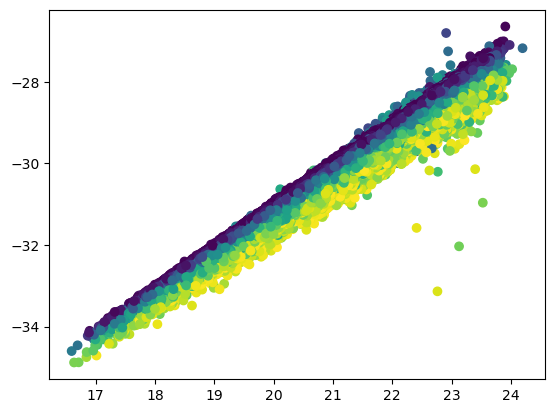

In [21]:
iz = 0
plt.scatter(apr_mag_g,abs_mag_g,c=z)